In [25]:
import os

import torch as ch
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# generate random indices dividing data into train, test, and val sets
class Partition(object):
    def __init__(self, ntotal, ntrain, ntest, nval, idx=None):
        super(Partition, self).__init__()
        # always generate the same random partition, for now
        np.random.seed(0)
        self.ntotal = ntotal
        self.ntrain = ntrain
        self.ntest = ntest
        self.nval = nval
        
        # so we can supply the idx if we want to use the same partition scheme
        if idx:
            self.idx = idx
        else:
            self.idx = np.random.choice(ntotal,ntotal)
            
        self.train_idx = self.idx[:ntrain]
        
        test_and_val_idx = self.idx[ntrain:]
        self.test_idx = test_and_val_idx[:ntest]
        self.val_idx = test_and_val_idx[ntest:]
    
    def __call__(self, X):
        return X[self.train_idx], X[self.test_idx], X[self.val_idx]
    
partition = Partition(1100, 900, 100, 100)

In [5]:
data = h5.File('kk_temporal_data.h5', 'r')

# input images
Stimuli = data['images']['raw'][:].transpose(0,3,2,1)

# get reps, averaging over time window 70-170 (idx 0) and over trials (last idx)
M_R = data['neural']['magneto']['right'][7:17].mean(axis=0).mean(axis=-1)
N_R = data['neural']['nano']['right'][7:17].mean(axis=0).mean(axis=-1)
N_L = data['neural']['nano']['left'][7:17].mean(axis=0).mean(axis=-1)

## make up labels for development
Y = np.array([np.ones(100)*i for i in range(11)]).reshape(-1)

In [6]:
M_R_neurons = M_R.shape[-1]
N_R_neurons = N_R.shape[-1]
N_L_neurons = N_L.shape[-1]

print(M_R_neurons, N_R_neurons, N_L_neurons)

157 142 187


In [7]:
# let's just manually divide each monkey neurons into train and val now, and only keep train
def partition_neurons(X, ntrain):
    np.random.seed(0)
    idx = np.random.choice(X.shape[-1], X.shape[-1])
    return X[:,idx[:ntrain]], X[:,idx[ntrain:]]


M_R = partition_neurons(M_R, 107)[0]
N_R = partition_neurons(N_R, 92)[0]
N_L = partition_neurons(N_L, 137)[0]

M_R_neurons = M_R.shape[-1]
N_R_neurons = N_R.shape[-1]
N_L_neurons = N_L.shape[-1]

print(M_R_neurons, N_R_neurons, N_L_neurons)

107 92 137


In [8]:
# now we can combine into one set
Reps = np.concatenate([M_R, N_R, N_L], axis=1)
Reps.shape

(1100, 336)

In [46]:
# partition the datasets
Stimuli_Partitioned = partition(Stimuli)

Reps_Partitioned = partition(Reps)

Y_Partitioned = partition(Y)

In [47]:
# lets save these as is; the loader will then pick them up from .npzs
partitions = ['Train', 'Test', 'Val']

name = 'Stimuli'
for S, P in zip(Stimuli_Partitioned, partitions):
    np.save(os.path.join('data', f'{name}_{P}'), S)
    
name = 'Reps'
for S, P in zip(Reps_Partitioned, partitions):
    np.save(os.path.join('data', f'{name}_{P}'), S)

name = 'Labels'
for S, P in zip(Y_Partitioned, partitions):
    np.save(os.path.join('data', f'{name}_{P}'), S)

In [49]:
partitions = ['Train', 'Test']

name = 'Stimuli'
Stimuli_Partitioned = [
    np.load(os.path.join('data', f'{name}_{P}.npy'))
    for P in partitions
]

name = 'Reps'
Reps_Partitioned = [
    np.load(os.path.join('data', f'{name}_{P}.npy'))
    for P in partitions
]

name = 'Labels'
Labels_Partitioned = [
    np.load(os.path.join('data', f'{name}_{P}.npy'))
    for P in partitions
]

In [51]:
from torch.utils.data import TensorDataset, DataLoader

# now they can be formatted at pytorch Dataset
Neural_Train, Neural_Test = [
    TensorDataset(
        ch.Tensor(Stimuli_Partitioned[i]), 
        ch.Tensor(Reps_Partitioned[i]), 
        ch.Tensor(Y_Partitioned[i])
    )
    for i in range(len(partitions))
]

In [52]:
for (stimuli, rep, label) in DataLoader(Neural_Train, batch_size=64):
    pass

tensor(10.) torch.Size([4, 336])


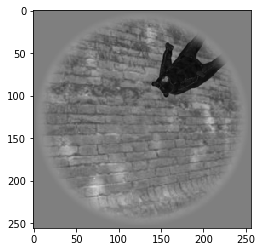

In [53]:
# and check that the images are still good:
plt.imshow(stimuli.detach().numpy()[2]/255)
print(label[0], rep.shape)

In [15]:
## now we need to merge w/ ImageNet loader.

In [16]:
## define the ImageNet dataset (mock)
import torchvision

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])

ImageNet_Train = torchvision.datasets.ImageFolder(
            'imagenet/',
            torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                normalize,
            ]))

In [17]:
from torchvision import datasets

# and concat the two:
class ConcatDataset(ch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

train_loader = ch.utils.data.DataLoader(
             ConcatDataset(
                 ImageNet_Train,
#                  ImageNet_Train
                 Neural_Train
             ),
             batch_size=4, shuffle=True,
             num_workers=4, pin_memory=True
)

In [18]:
# the new train_loader:
for ((imnet_inp, imnet_label), (stimuli, rep, label)) in train_loader:
    print(f'{imnet_inp.shape}, {imnet_label.shape}, {stimuli.shape}, {rep.shape}, {label.shape}')

torch.Size([4, 3, 224, 224]), torch.Size([4]), torch.Size([4, 256, 256, 3]), torch.Size([4, 336]), torch.Size([4])
torch.Size([4, 3, 224, 224]), torch.Size([4]), torch.Size([4, 256, 256, 3]), torch.Size([4, 336]), torch.Size([4])
torch.Size([4, 3, 224, 224]), torch.Size([4]), torch.Size([4, 256, 256, 3]), torch.Size([4, 336]), torch.Size([4])
torch.Size([4, 3, 224, 224]), torch.Size([4]), torch.Size([4, 256, 256, 3]), torch.Size([4, 336]), torch.Size([4])
torch.Size([2, 3, 224, 224]), torch.Size([2]), torch.Size([2, 256, 256, 3]), torch.Size([2, 336]), torch.Size([2])
